In [5]:
# =========================
# Diffusion: ESM vs DSM (1D Gaussian)
# Ready-to-run PyTorch script
# =========================
import math, os, random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# ----- Repro -----
SEED = 1234
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Data spec -----
MU = 3.0                 # data mean
SIG_DATA = 1.0           # sigma_data
# noise levels to try for DSM (will train one per sigma)
DSM_NOISES = [0.1, 0.3, 0.7, 1.0]

N_TRAIN = 50_000
N_VAL   = 10_000
N_TEST  = 10_000

# ----- Train config -----
BATCH = 256
LR    = 1e-3
STEPS = 4_000
PRINT_EVERY = 200
EMA_DECAY = 0.999



In [6]:
# =========================
# Utilities
# =========================
def sample_data(n, mu=MU, sig=SIG_DATA, device=DEVICE):
    x = torch.randn(n, 1, device=device) * sig + mu
    return x

def true_score(x, mu=MU, sig=SIG_DATA):
    # s*(x) = -(x-mu)/sig^2
    return -(x - mu) / (sig**2)

@torch.no_grad()
def make_grid(xmin=-2, xmax=8, num=400, device=DEVICE):
    g = torch.linspace(xmin, xmax, num, device=device).view(-1,1)
    return g

class EMA:
    def __init__(self, model, decay=EMA_DECAY):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()

    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1.0-self.decay)

    def copy_to(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.shadow[n])

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import deque

def current_lr(optimizer):
    for pg in optimizer.param_groups:
        return pg["lr"]

def make_plateau_scheduler(optimizer,
                           factor=0.5,      # 降多少倍
                           patience=5,      # 幾次無改善才降
                           threshold=1e-4,  # 改善門檻
                           min_lr=1e-5,     # 最小 lr
                           cooldown=0):     # 冷卻期
    return ReduceLROnPlateau(optimizer, mode="min",
                             factor=factor, patience=patience,
                             threshold=threshold, min_lr=min_lr,
                             cooldown=cooldown, verbose=True)

class EarlyStopper:
    def __init__(self, patience=20, min_delta=0.0):
        self.best = None
        self.count = 0
        self.patience = patience
        self.min_delta = min_delta

    def step(self, value):
        if self.best is None or value < self.best - self.min_delta:
            self.best = value
            self.count = 0
            return False
        else:
            self.count += 1
            return self.count >= self.patience


In [11]:
# =========================
# Model
# =========================
class ScoreMLP(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1),
        )
        # small init on final to stabilize early training
        nn.init.zeros_(self.net[-1].weight); nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        return self.net(x)

# =========================
# Training loops
# =========================
def train_esm(hidden=64, warmup_steps=300):
    model = ScoreMLP(hidden).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98))
    sched = make_plateau_scheduler(opt, factor=0.2, patience=2, threshold=1e-3, min_lr=1e-5)
    ema = EMA(model, EMA_DECAY)

    x_tr = sample_data(N_TRAIN)
    x_va = sample_data(N_VAL)

    tr_hist, va_hist = [], []
    ma = deque(maxlen=20)  # 平滑 val loss
    stopper = EarlyStopper(patience=40, min_delta=0.0)

    base_lr = LR

    for step in range(1, STEPS+1):
        # ---- warm-up ----
        if step <= warmup_steps:
            scale = step / warmup_steps
            for pg in opt.param_groups:
                pg["lr"] = base_lr * scale

        # ---- train step ----
        idx = torch.randint(0, x_tr.shape[0], (BATCH,), device=DEVICE)
        x = x_tr[idx]
        target = true_score(x)
        pred = model(x)
        loss = F.mse_loss(pred, target)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        ema.update(model)

        # ---- validation & plateau check ----
        if step % PRINT_EVERY == 0 or step == 1:
            with torch.no_grad():
                ema.copy_to(model)
                pv = model(x_va)
                tv = true_score(x_va)
                vloss = F.mse_loss(pv, tv).item()

            ma.append(vloss)
            vsm = sum(ma) / len(ma)  # smoothed val

            # ReduceLROnPlateau 依據平滑後 val loss 做判斷
            old_lr = current_lr(opt)
            sched.step(vsm)
            new_lr = current_lr(opt)
            if new_lr < old_lr:
                print(f"[ESM] step={step} plateau detected → lr {old_lr:.3e} → {new_lr:.3e}")

            tr_hist.append((step, loss.item()))
            va_hist.append((step, vloss))
            print(f"[ESM] step={step:5d} train={loss.item():.6f}  val(MSE true)={vloss:.6f}  lr={new_lr:.3e}")

            # optional early stop
            if stopper.step(vsm):
                print(f"[ESM] Early stop at step {step} (best val≈{stopper.best:.6f})")
                break

    with torch.no_grad():
        ema.copy_to(model)
    return model, np.array(tr_hist), np.array(va_hist)


def train_dsm(sig_noise, hidden=64, warmup_steps=300):
    model = ScoreMLP(hidden).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98))
    sched = make_plateau_scheduler(opt, factor=0.2, patience=2, threshold=1e-3, min_lr=1e-5)
    ema = EMA(model, EMA_DECAY)

    x0_tr = sample_data(N_TRAIN)
    x0_va = sample_data(N_VAL)

    tr_hist, va_hist = [], []
    ma = deque(maxlen=20)
    stopper = EarlyStopper(patience=40, min_delta=0.0)
    base_lr = LR

    for step in range(1, STEPS+1):
        # warm-up
        if step <= warmup_steps:
            scale = step / warmup_steps
            for pg in opt.param_groups:
                pg["lr"] = base_lr * scale

        # train step
        idx = torch.randint(0, x0_tr.shape[0], (BATCH,), device=DEVICE)
        x0 = x0_tr[idx]
        eps = torch.randn_like(x0)
        x = x0 + sig_noise * eps
        target = -(x - x0) / (sig_noise**2)

        pred = model(x)
        loss = F.mse_loss(pred, target)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        ema.update(model)

        # validation & plateau
        if step % PRINT_EVERY == 0 or step == 1:
            with torch.no_grad():
                ema.copy_to(model)
                idv = torch.randint(0, x0_va.shape[0], (BATCH*4,), device=DEVICE)
                x0v = x0_va[idv]
                epsv = torch.randn_like(x0v)
                xv = x0v + sig_noise * epsv
                tv = -(xv - x0v) / (sig_noise**2)
                vloss = F.mse_loss(model(xv), tv).item()

            ma.append(vloss)
            vsm = sum(ma) / len(ma)

            old_lr = current_lr(opt)
            sched.step(vsm)
            new_lr = current_lr(opt)
            if new_lr < old_lr:
                print(f"[DSM σ={sig_noise}] step={step} plateau → lr {old_lr:.3e} → {new_lr:.3e}")

            tr_hist.append((step, loss.item()))
            va_hist.append((step, vloss))
            print(f"[DSM σ={sig_noise}] step={step:5d} train={loss.item():.6f}  val(MSE cond)={vloss:.6f}  lr={new_lr:.3e}")

            if stopper.step(vsm):
                print(f"[DSM σ={sig_noise}] Early stop at step {step} (best val≈{stopper.best:.6f})")
                break

    with torch.no_grad():
        ema.copy_to(model)
    return model, np.array(tr_hist), np.array(va_hist)


Device: cpu
[ESM] step=    1 train=0.912900  val(MSE true)=1.010779  lr=3.333e-06
[ESM] step=  200 train=0.029983  val(MSE true)=0.966333  lr=6.667e-04
[ESM] step=  400 train=0.005889  val(MSE true)=0.852041  lr=1.000e-03
[ESM] step=  600 train=0.001186  val(MSE true)=0.712650  lr=1.000e-03
[ESM] step=  800 train=0.001412  val(MSE true)=0.571272  lr=1.000e-03
[ESM] step= 1000 train=0.000962  val(MSE true)=0.444480  lr=1.000e-03
[ESM] step= 1200 train=0.001677  val(MSE true)=0.337114  lr=1.000e-03
[ESM] step= 1400 train=0.000836  val(MSE true)=0.250325  lr=1.000e-03
[ESM] step= 1600 train=0.000279  val(MSE true)=0.183019  lr=1.000e-03
[ESM] step= 1800 train=0.000299  val(MSE true)=0.132066  lr=1.000e-03
[ESM] step= 2000 train=0.000289  val(MSE true)=0.094220  lr=1.000e-03
[ESM] step= 2200 train=0.000220  val(MSE true)=0.066610  lr=1.000e-03
[ESM] step= 2400 train=0.000039  val(MSE true)=0.046582  lr=1.000e-03
[ESM] step= 2600 train=0.000061  val(MSE true)=0.032324  lr=1.000e-03
[ESM] st

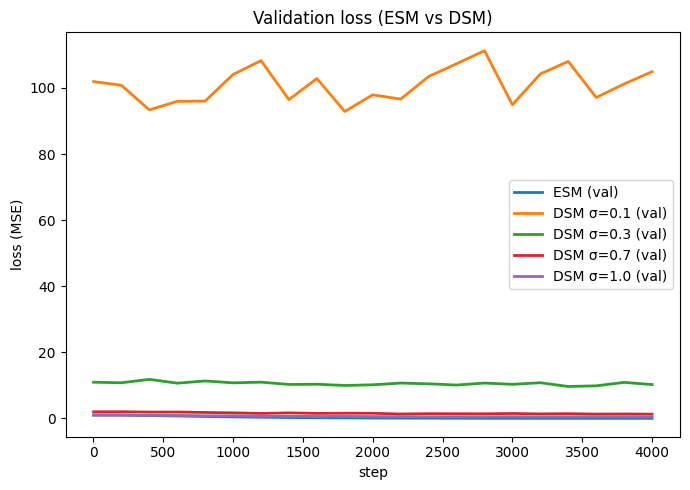

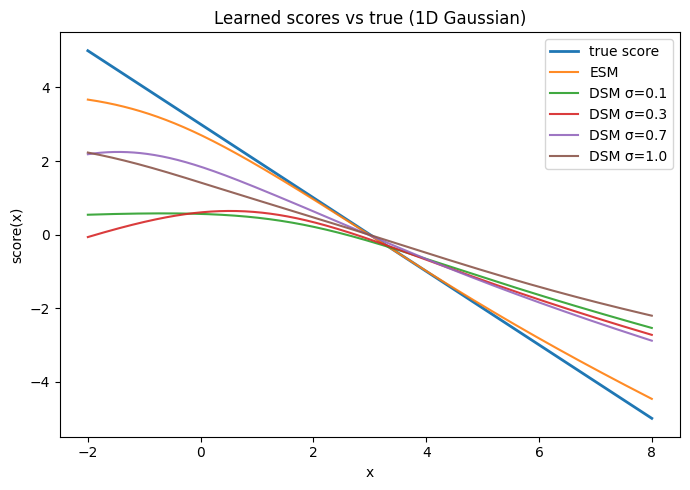

In [12]:
# =========================
# Evaluation helpers
# =========================
@torch.no_grad()
def eval_true_score_mse(model):
    # evaluate MSE on an i.i.d. sample from p_data against true score
    x_te = sample_data(N_TEST)
    mse = F.mse_loss(model(x_te), true_score(x_te)).item()
    return mse

@torch.no_grad()
def plot_scores(models_dict, title_suffix=""):
    grid = make_grid(-2, 8, 600)
    s_true = true_score(grid).cpu().numpy()

    plt.figure(figsize=(7,5))
    plt.plot(grid.cpu().numpy(), s_true, label="true score", linewidth=2)

    for name, mdl in models_dict.items():
        s_hat = mdl(grid).cpu().numpy()
        plt.plot(grid.cpu().numpy(), s_hat, label=name, alpha=0.9)
    plt.xlabel("x"); plt.ylabel("score(x)")
    plt.title(f"Learned scores vs true{title_suffix}")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_curves(curves, title, colors=None, linewidth=2.0):
    plt.figure(figsize=(7,5))
    for i, (label, arr) in enumerate(curves):
        steps, vals = arr[:,0], arr[:,1]
        kw = {}
        if colors is not None and i < len(colors):
            kw["color"] = colors[i]
        plt.plot(steps, vals, label=label, linewidth=linewidth, **kw)
    plt.xlabel("step"); plt.ylabel("loss (MSE)")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# =========================
# Run experiments (calls the NEW train_esm/train_dsm with LR scheduling)
# =========================
if __name__ == "__main__":
    print("Device:", DEVICE)

    # ---- Train ESM (with warmup & plateau scheduler inside) ----
    esm_model, esm_tr, esm_va = train_esm(hidden=64, warmup_steps=300)
    esm_mse = eval_true_score_mse(esm_model)
    print(f"\n[ESM] test MSE vs true score = {esm_mse:.6f}")

    # ---- Train DSM for each sigma_noise ----
    dsm_models = {}
    dsm_val_curves = {}   # keep val curves keyed by sigma
    for sig in DSM_NOISES:
        mdl, tr, va = train_dsm(sig_noise=sig, hidden=64, warmup_steps=300)
        dsm_models[f"DSM σ={sig}"] = mdl
        dsm_val_curves[sig] = va
        mse = eval_true_score_mse(mdl)  # 注意：和 true score 比較（σ>0 時會偏）
        print(f"[DSM σ={sig}] test MSE vs true score = {mse:.6f}")

    # -------- Plots --------
    # (1) Training/validation curves — ESM + ALL DSM curves (恢復成以前的樣子)
    all_curves = [("ESM (val)", esm_va)]
    for sig in DSM_NOISES:
        if sig in dsm_val_curves:
            all_curves.append((f"DSM σ={sig} (val)", dsm_val_curves[sig]))
    plot_curves(all_curves, title="Validation loss (ESM vs DSM)")

    # (2) Learned score on a grid — 也維持全部模型一起畫
    plot_scores({"ESM": esm_model, **dsm_models}, title_suffix=" (1D Gaussian)")


---

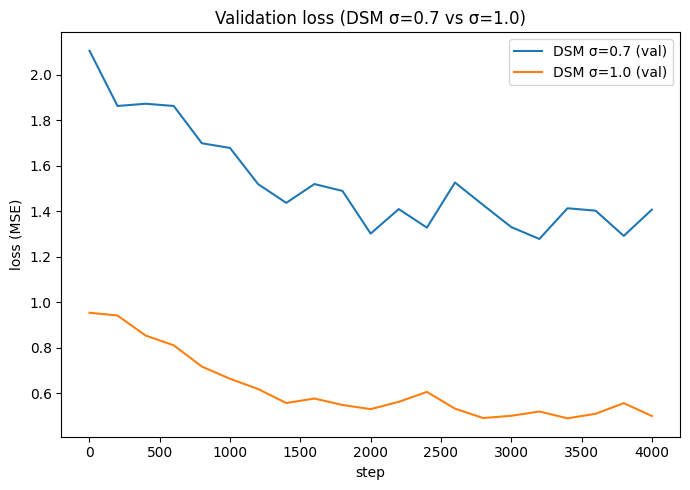

In [3]:
# -------- Plots --------
# 1) Only DSM σ=0.7 and DSM σ=1.0
selected = [arr for arr in dsm_curves if ("σ=0.7" in arr[0]) or ("σ=1.0" in arr[0])]
plot_curves(selected, title="Validation loss (DSM σ=0.7 vs σ=1.0)")
